# Labeled VAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'vae.labeled'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32

In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222 * 24 * 24
hidden_dim = 128
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

model = M.vae.LabeledVAE(input_dim, hidden_dim, latent_dim, classes_dim)
criterion = M.vae.Loss()

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.vae.LabeledVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1432590.000000
INFO | epoch 1 ( 35%) loss: 159032.142907
INFO | epoch 1 ( 70%) loss: 86802.182486
INFO | epoch 1 (100%) loss: 65254.369437
INFO | epoch 1 (test) loss: 10335.540726
INFO | epoch 2 (  0%) loss: 11359.992188
INFO | epoch 2 ( 35%) loss: 9687.071415
INFO | epoch 2 ( 70%) loss: 9047.255998
INFO | epoch 2 (100%) loss: 8529.424603
INFO | epoch 2 (test) loss: 6805.975708
INFO | epoch 3 (  0%) loss: 7279.046875
INFO | epoch 3 ( 35%) loss: 6662.333849
INFO | epoch 3 ( 70%) loss: 6393.909947
INFO | epoch 3 (100%) loss: 6204.867654
INFO | epoch 3 (test) loss: 5401.465302
INFO | epoch 4 (  0%) loss: 5010.911133
INFO | epoch 4 ( 35%) loss: 5350.365553
INFO | epoch 4 ( 70%) loss: 5206.670087
INFO | epoch 4 (100%) loss: 5084.625072
INFO | epoch 4 (test) loss: 4566.013216
INFO | epoch 5 (  0%) loss: 4873.926758
INFO | epoch 5 ( 35%) 

# Results

In [9]:
# Generate new image

z = torch.randn(1, latent_dim).to(device)
with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0].view(222, 24, 24)
print(decoded_one_hot.shape)


torch.Size([1, 127872])
torch.Size([222, 24, 24])


torch.Size([4, 24, 24])


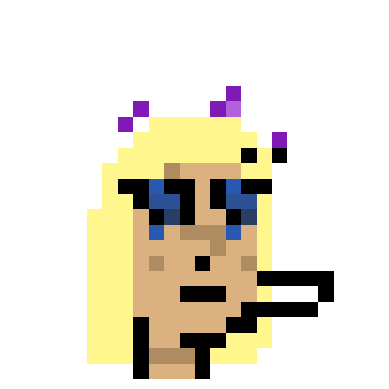

In [10]:
decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


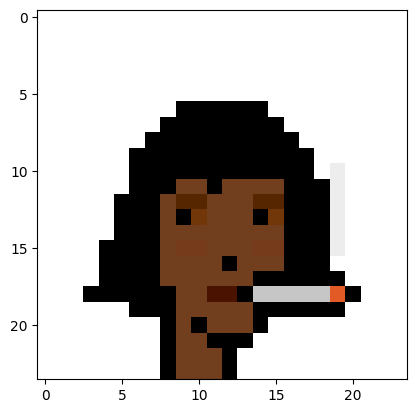

In [11]:
punk, punk_labels = dataset[1000]
punk = DS.one_hot_to_rgba(punk, dataset.mapper)

plt.imshow(transforms.functional.to_pil_image(punk))
plt.show()

torch.Size([1, 222, 24, 24])


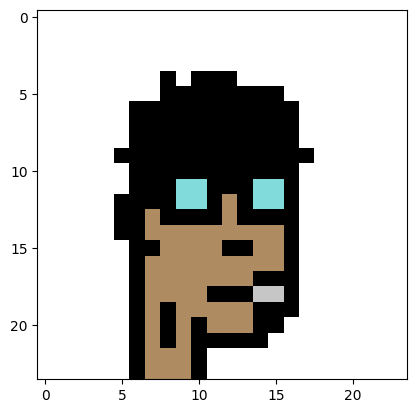

In [40]:
punk, punk_labels = dataset[1000]

punk_labels = punk_labels.unsqueeze(0).to(device)

# punk = I.get_punk_tensor(1000)

p = DS.rgba_to_one_hot(punk, dataset.mapper)
p = p.unsqueeze(0)
p = p.to(device)

model.eval()
with torch.no_grad():
    reconstructed, mu, logcar = model.forward(p, punk_labels)
    print(reconstructed.shape)

recon_punk = reconstructed[0].cpu()
recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)
plt.imshow(transforms.functional.to_pil_image(recon_punk.cpu()))
plt.show()


## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

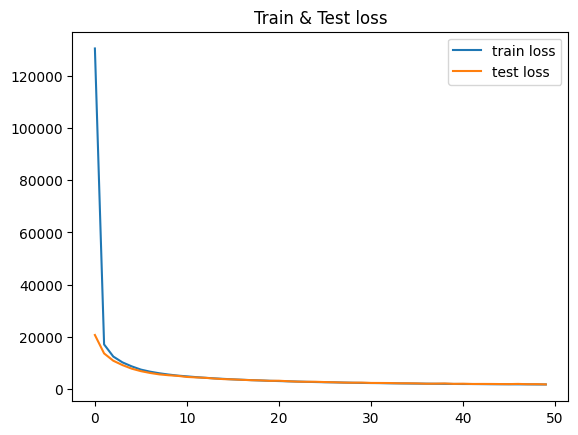

In [13]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [14]:
train_losses


[130508.73887342088,
 17058.849205936946,
 12409.735307409408,
 10169.250143713985,
 8651.022692091921,
 7405.496835262217,
 6610.499149836547,
 5999.93114974651,
 5509.680510392426,
 5106.724253553025,
 4810.672667158411,
 4521.084789519615,
 4267.436477985788,
 4041.9835676910184,
 3848.5509007230717,
 3662.695665724734,
 3514.7978900882367,
 3366.7782882798647,
 3239.6365793647497,
 3113.053879758145,
 3018.576984378463,
 2911.1853715612533,
 2813.475425341451,
 2714.5174136330897,
 2641.454783771055,
 2564.234200119127,
 2515.265743607325,
 2432.2606365663787,
 2365.743024244376,
 2300.837257331145,
 2254.9076324895764,
 2224.934538929175,
 2154.763943286652,
 2124.849459925442,
 2077.7143673727696,
 2044.3717342944856,
 2008.5603111754072,
 1968.1893293231938,
 1948.205150414866,
 1907.5292177673773,
 1886.712786951809,
 1878.4555603460217,
 1841.8779474353114,
 1806.353830323997,
 1787.769686651568,
 1772.3861107792416,
 1756.953971267592,
 1748.376168974748,
 1711.705843986349,


In [15]:
test_losses


[20671.081451416016,
 13611.951416015625,
 10802.930603027344,
 9132.026432037354,
 7768.659233093262,
 6813.319953918457,
 6118.854339599609,
 5577.212532043457,
 5246.897193908691,
 5002.654392242432,
 4594.898666381836,
 4407.5747718811035,
 4250.432479858398,
 3973.4940338134766,
 3758.546184539795,
 3649.998586654663,
 3489.5251598358154,
 3347.6675510406494,
 3266.7979526519775,
 3103.6825790405273,
 3136.374496459961,
 2949.0087146759033,
 2796.407943725586,
 2741.9794273376465,
 2741.34627532959,
 2625.0236778259277,
 2546.5787601470947,
 2439.6060791015625,
 2386.3636150360107,
 2414.7277088165283,
 2293.2143230438232,
 2280.924042701721,
 2256.9334087371826,
 2167.062755584717,
 2162.985062599182,
 2113.1789026260376,
 1996.6701641082764,
 2022.97749710083,
 2091.1273345947266,
 1936.4910745620728,
 1988.0128993988037,
 1893.829659461975,
 1908.1991271972656,
 1898.2217979431152,
 1868.7663764953613,
 1845.591052055359,
 1917.9024810791016,
 1806.5982971191406,
 1825.61683845